In [ ]:
import tensorflow as tf
from MNISTData import MNISTData 
from MITOS12Data import MITOS12Data
from JPHAlguesData import JPHAlguesData
from matplotlib import pyplot as plt
import numpy as np
from sys import stdout
from networkViz import *
from NetworkLayer import *
from WeightInit import WeightInit

from Network import Network
%matplotlib inline

In [ ]:
def next_batch(batch_size):
    c1 = np.array([-0.4, -0.4, 0.5])
    c2 = np.array([0., -0.1, 0.7])
    r = np.random.rand(batch_size) > 0.5
    e = np.random.rand(batch_size,3)-0.5
    batch = np.zeros((batch_size,3))
    batch[r==True,:] = c1+e[r==True,:]*0.3
    batch[r==False,:] = c2+e[r==False,:]*0.3
    return batch, r

In [ ]:
model = {
    'inputLayer' : FlatInputLayer(inputsize=3),
    'hiddenLayers' : [
        FullyConnectedLayer(inputsize=3,outputsize=2,weightInitFunc=WeightInit.truncatedNormal,biasInitFunc=WeightInit.positive,activationFunc=tf.nn.relu),
    ]
}

In [ ]:
net = Network(model, objective='reconstruction', batch_size=50)

net.setupTraining("squared-diff", "Adam", False)
init = tf.initialize_all_variables()

saver = tf.train.Saver()
sess = tf.Session()

In [ ]:
sess.run(init)

In [ ]:
with sess.as_default():
    print net.layers[1].W.eval()
    print net.layers[1].b.eval()
    #print net.l2loss.eval()
    b,r = next_batch(50)
    e = net.encode(b)
    bb = [net.decode([ee]) for ee in e]
    plt.figure()
    plt.plot(e[r,0], e[r,1], 'bo')
    plt.plot(e[r==False,0], e[r==False,1], 'ro')
    plt.show()

In [ ]:
with sess.as_default():
    for i in range(20000):
        b,r = next_batch(50)
        net.train(b, b)
        if( i%2000 == 0 ):
            cost = net.cost.eval(feed_dict={net.x: b, net.target: b})
            print "step %d, training cost %g"%(i,cost)
            #print "step %d, training cost %g, l2loss %g"%(i,cost,net.l2loss.eval())

In [ ]:
with sess.as_default():
    print net.layers[1].W.eval()
    print net.layers[1].b.eval()
    b,r = next_batch(50)
    e = net.encode(b)
    bb = [net.decode([ee]) for ee in e]
    plt.figure()
    plt.plot(e[r,0], e[r,1], 'bo')
    plt.plot(e[r==False,0], e[r==False,1], 'ro')
    plt.show()

In [1]:
import tensorflow as tf
from MNISTData import MNISTData 
from MITOS12Data import MITOS12Data
from JPHAlguesData import JPHAlguesData
from matplotlib import pyplot as plt
import numpy as np
from sys import stdout
from networkViz import *
from NetworkLayer import *
from WeightInit import WeightInit

from Network import Network
%matplotlib inline

mnist = MNISTData(train_dir='MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# Building the network
def build_graph():
    net_input = tf.placeholder(tf.float32, [None, 784])
    
    # Fully connected layer
    w_01 = tf.Variable(tf.truncated_normal([784, 100], stddev=0.1))
    b_1 = tf.Variable(tf.constant(0.), [100])
    l_1 = tf.nn.relu(tf.matmul(net_input, w_01)+b_1)
    
    # Softmax layer
    w_12 = tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))
    b_2 = tf.Variable(tf.constant(0.), [10])
    l_2 = tf.nn.softmax(tf.matmul(l_1, w_12)+b_2)
    
    return net_input,l_2, [w_01, b_1, w_12, b_2]

In [6]:
sess = tf.Session()

In [8]:
target = tf.placeholder(tf.float32, [None,10], "Target")
_in,_out,Ws = build_graph()

a = 0.9
loss = (a*-tf.reduce_sum(target*tf.log(_out)))+(1-a)*tf.add_n([tf.nn.l2_loss(w) for w in Ws])
trainingStep = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [9]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [10]:
kf = StratifiedKFold(mnist.train['labels'].argmax(axis=1),5)

for train,test in kf:
    X_train = mnist.train['images'][train]
    Y_train = mnist.train['labels'][train]
    
    X_test = mnist.train['images'][test]
    Y_test = mnist.train['labels'][test]
    break

In [11]:
batch_order = range(len(X_train))
init = tf.initialize_all_variables()

with sess.as_default():
    sess.run(init)
    for i in range(20000):
        np.random.shuffle(batch_order)
        mini_batch = (X_train[batch_order[:100]], Y_train[batch_order[:100]])
        trainingStep.run(feed_dict={_in: mini_batch[0], target: mini_batch[1]})
        
        if i%2000 == 0:
            pred = _out.eval(feed_dict={_in: X_test})
            C = confusion_matrix(Y_test.argmax(axis=1), pred.argmax(axis=1))
            print "Prediction score : %.2f"%(C.diagonal().sum()*1./C.sum())

Prediction score : 0.15
Prediction score : 0.93
Prediction score : 0.95
Prediction score : 0.96
Prediction score : 0.96
Prediction score : 0.96
Prediction score : 0.96
Prediction score : 0.97
Prediction score : 0.97
Prediction score : 0.97


-0.370095 0.304111 -0.000366146 0.0346317


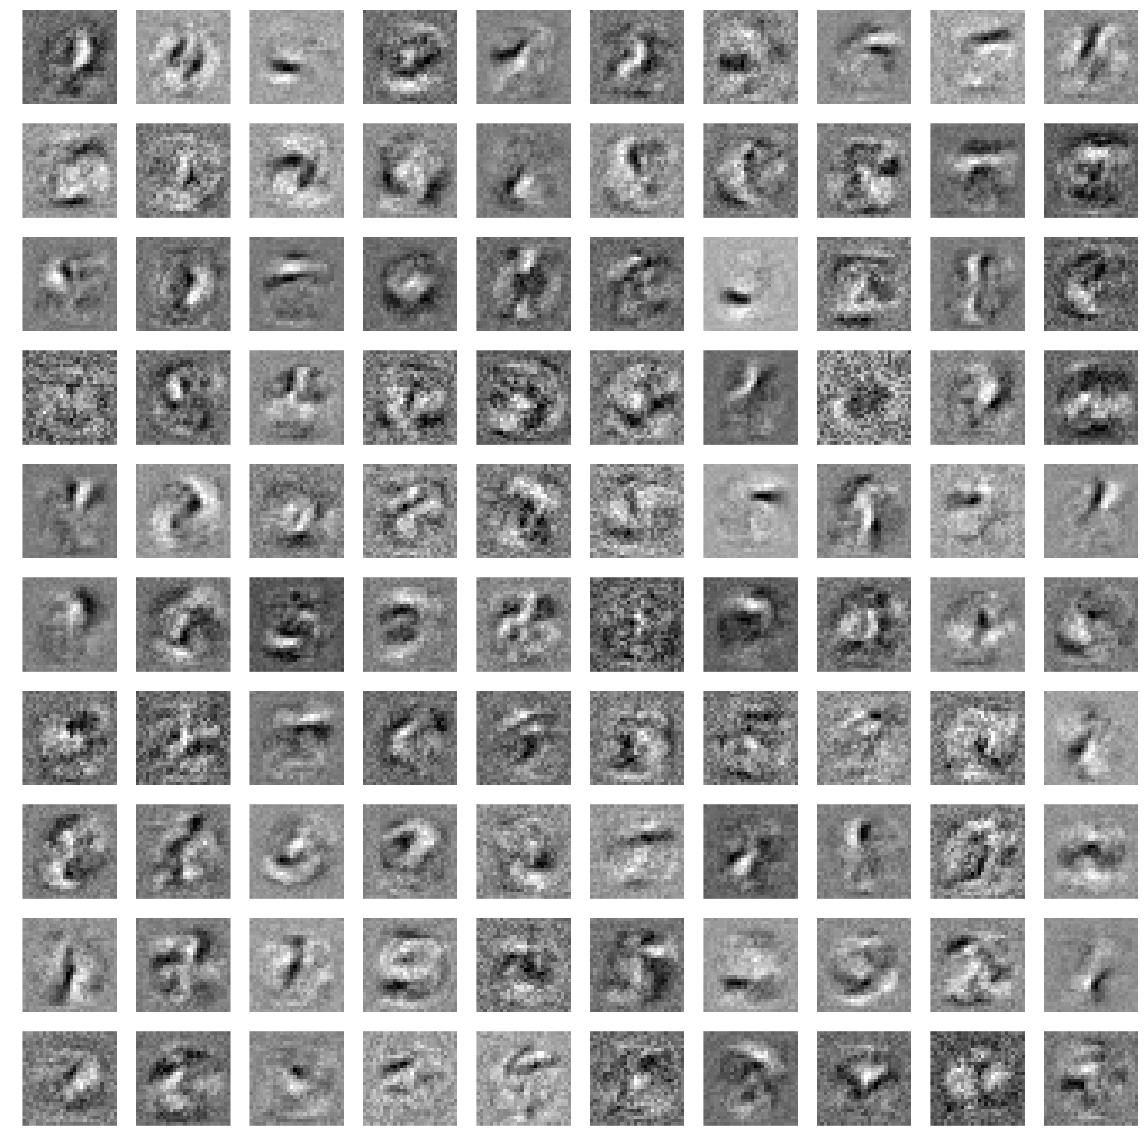

In [12]:
# Exploring the weights
W = _out.op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[1].eval(session=sess)
print W.min(), W.max(), W.mean(), W.std()

plt.figure(figsize=(20,20))
plt.gray()
for k in range(100):
    Wk = W[:,k].reshape((28,28))
    plt.subplot(10,10,k+1)
    plt.imshow(Wk, interpolation='none')
    plt.axis('off')
plt.show()